# Age Transformation Demo

This demo focuses on the following aspects:

- Loading and running pretrained K-SAM generators
- Explicit control of source age → target age
- Stage-wise inference (Stage-2 → Stage-3)
- Clean and reproducible inference on Google Colab

Due to the limited availability of identity-consistent age-paired data and constrained computational resources, the model’s optimization is biased toward preserving identity and texture consistency rather than learning large-scale age-dependent geometric transformations. As a result, aging effects manifested in the generated images are predominantly subtle and localized. This limitation is further exacerbated by the instability of age regression supervision on generated samples and is discussed in detail in the Limitations section.



## 1. Import

In [1]:
!pip install -q gdown

In [2]:
!pip install -q -r https://raw.githubusercontent.com/yoomstergotcha/K-SAM/master/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incomp

In [3]:
import os, sys

REPO_URL = "https://github.com/yoomstergotcha/K-SAM.git"
REPO_DIR = "/master"

if not os.path.exists(REPO_DIR):
    !git clone $REPO_URL $REPO_DIR

sys.path.append(REPO_DIR)

Cloning into '/master'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 391 (delta 27), reused 377 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (391/391), 1006.74 KiB | 18.99 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [68]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 2. Input Image & age control

The user uploads a single face image.
Two sliders control:
- **Source age** (assumed age of the input face)
- **Target age** (desired output age)

Both ages are clamped to the training range \([0, 80]\).

This explicit age control mirrors the conditioning mechanism used during training.


In [54]:
from ipywidgets import FileUpload
from PIL import Image
import io

uploader = FileUpload(accept="image/*", multiple=False)
display(uploader)

FileUpload(value={}, accept='image/*', description='Upload')

(np.float64(-0.5), np.float64(799.5), np.float64(1066.5), np.float64(-0.5))

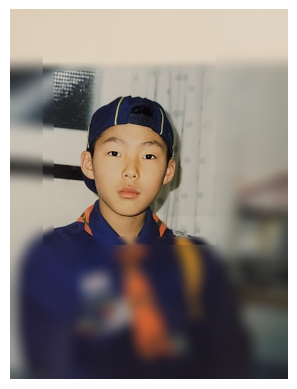

In [72]:
def load_uploaded_image(uploader):
    if len(uploader.value) == 0:
        raise RuntimeError("Please upload an image")

    content = list(uploader.value.values())[0]["content"]
    img = Image.open(io.BytesIO(content)).convert("RGB")
    return np.array(img)

img = load_uploaded_image(uploader)

plt.imshow(img); plt.axis("off")

In [76]:
from ipywidgets import IntSlider, HBox, VBox
import numpy as np
import torch

# --- Source age slider ---
age_src_slider = IntSlider(
    value=30,
    min=0,
    max=80,
    step=1,
    description="Source age",
    continuous_update=False
)

# --- Target age slider ---
age_tgt_slider = IntSlider(
    value=60,
    min=0,
    max=80,
    step=1,
    description="Target age",
    continuous_update=False
)

display(VBox([age_src_slider, age_tgt_slider]))


def get_age_tensor(age_value, device):
    """
    Convert age slider value to (1,1) float tensor on correct device.
    """
    age = np.clip(age_value, 0, 80)
    return torch.tensor([[float(age)]], device=device)

## Stage-wise Training Strategy (K-SAM)

The K-SAM generator is trained in multiple stages:


1. ###  Stage-1:  Pre-train external age regression model (SSRNet)

2. ### Stage-2: Reconstruction Backbone
    - Trained in reconstruction mode (source age = target age)
    - Focuses on identity preservation and stable decoding
    - Does not introduce strong age changes

3. ### Stage-3: Age-Conditioned Refinement
    - Introduces age conditioning via FiLM modulation
    - Refines the Stage-2 output toward the target age
    - Responsible for appearance-level aging cues

Both stages use a ResNet-based encoder with FiLM-conditioned decoder blocks. In this demo, Stage-3 outputs remain subtle due to limited training resources.


In [78]:
import torchvision.transforms as T

preprocess = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),                     # [0,255] → [0,1]
    T.Normalize(
        mean=[0.5, 0.5, 0.5],          # → [-1,1]
        std=[0.5, 0.5, 0.5]
    )
])

img_pil = Image.fromarray(img)
x = preprocess(img_pil).unsqueeze(0).to(device)

print("Input tensor:", x.shape, x.min().item(), x.max().item())

Input tensor: torch.Size([1, 3, 128, 128]) -0.9529411792755127 0.7568627595901489


## 3. Load checkpoints

In [79]:
import os
import gdown

CKPT_DIR = "/content/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

stage2_id = "1y48HmE_5Z6r-F_dN9Fu619HOAEoomx2A"
stage3_id = "1hPaSKaJEWiPo5pX9Ftxf0-dKAYACAufk"

stage2_path = f"{CKPT_DIR}/G_stage2.pt"
stage3_path = f"{CKPT_DIR}/G_stage3.pt"

if not os.path.exists(stage2_path):
    gdown.download(
        f"https://drive.google.com/uc?id={stage2_id}",
        stage2_path,
        quiet=False
    )

if not os.path.exists(stage3_path):
    gdown.download(
        f"https://drive.google.com/uc?id={stage3_id}",
        stage3_path,
        quiet=False
    )

In [80]:
import torch
from models.generator import SAMResNetFiLMGenerator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def load_generator(ckpt_path):
    G = SAMResNetFiLMGenerator().to(device)

    ckpt = torch.load(ckpt_path, map_location=device)

    # handle different checkpoint formats safely
    if isinstance(ckpt, dict):
        if "G" in ckpt:
            G.load_state_dict(ckpt["G"])
        elif "state_dict" in ckpt:
            G.load_state_dict(ckpt["state_dict"])
        else:
            G.load_state_dict(ckpt)
    else:
        G.load_state_dict(ckpt)

    G.eval()
    return G

Using device: cpu


## 4. Inference

In [81]:
age_src = get_age_tensor(age_src_slider.value, device)
age_tgt = get_age_tensor(age_tgt_slider.value, device)

In [82]:
G_stage2 = SAMResNetFiLMGenerator(
    age_emb_dim=128
).to(device)

G_stage3 = SAMResNetFiLMGenerator(
    age_emb_dim=128
).to(device)

In [83]:
state_dict = torch.load(stage2_path, map_location="cpu")

if isinstance(state_dict, dict) and "G" in state_dict:
    state_dict = state_dict["G"]

patched = {}
for k, v in state_dict.items():
    if k.startswith("landmark_head."):
        patched["lm_fc." + k[len("landmark_head."):]] = v
    else:
        patched[k] = v

state_dict = patched

missing, unexpected = G_stage2.load_state_dict(state_dict, strict=False)

G_stage2.eval()
print("Stage-2 generator loaded")

Stage-2 generator loaded


In [84]:
state_dict = torch.load(stage3_path, map_location="cpu")

if isinstance(state_dict, dict) and "G" in state_dict:
    state_dict = state_dict["G"]

patched = {}
for k, v in state_dict.items():
    if k.startswith("landmark_head."):
        # old naming → new lm_fc
        patched["lm_fc." + k[len("landmark_head."):]] = v
    else:
        patched[k] = v

state_dict = patched

missing, unexpected = G_stage3.load_state_dict(state_dict, strict=False)

G_stage3.eval()
print("Stage-3 generator loaded")

Stage-3 generator loaded


In [90]:
with torch.no_grad():
    img2, _ = G_stage2(x, age_src, age_tgt)
    img3, _ = G_stage3(x, age_src, age_tgt)

In [89]:
def tensor_to_img(t):
    t = t.clamp(-1, 1)
    t = (t + 1) / 2
    img = t[0].permute(1, 2, 0).detach().cpu().numpy()
    return (img * 255).astype("uint8")

In [91]:
img_stage2 = tensor_to_img(img2)
img_stage3 = tensor_to_img(img3)

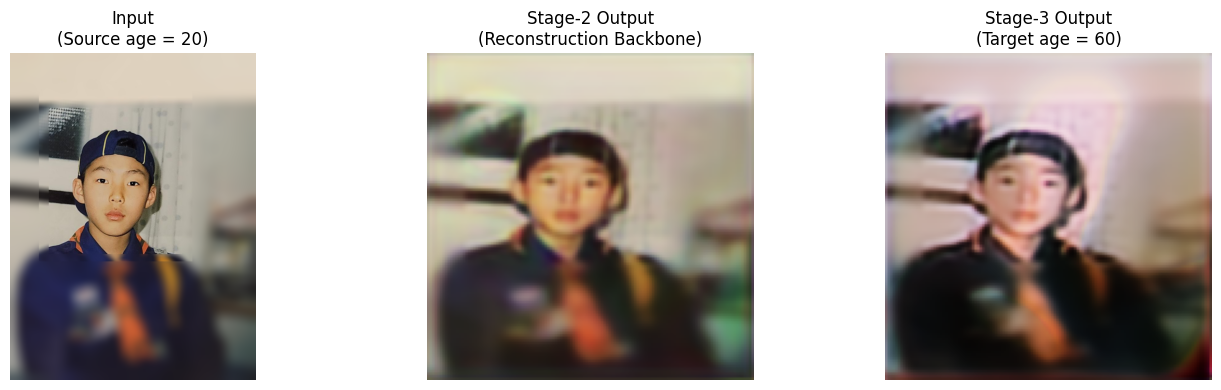

In [92]:
plt.figure(figsize=(14, 4))

# --- Input ---
plt.subplot(1, 3, 1)
plt.title(f"Input\n(Source age = {age_src_slider.value})")
plt.imshow(img)
plt.axis("off")

# --- Stage-2 ---
plt.subplot(1, 3, 2)
plt.title("Stage-2 Output\n(Reconstruction Backbone)")
plt.imshow(img_stage2)
plt.axis("off")

# --- Stage-3 ---
plt.subplot(1, 3, 3)
plt.title(f"Stage-3 Output\n(Target age = {age_tgt_slider.value})")
plt.imshow(img_stage3)
plt.axis("off")

plt.tight_layout()
plt.show()


## 5. Results & Limitations

Despite the structured training pipeline and extensive experimentation, several limitations remain in the proposed K-SAM framework.

- The effectiveness of age supervision in Stage 3 is constrained by the stability of the age estimation model. While SSRNet was pre-trained and validated on real images, its predictions on generated samples exhibited high variance and systematic bias. This caused the age regression loss to fluctuate during training and limited its usefulness as a reliable supervisory signal. Consequently, age guidance provided by SSRNet often failed to enforce monotonic or consistent aging behavior in the generated outputs.

- The generator architecture, although equipped with FiLM-based age conditioning and landmark supervision, remains fundamentally image-space driven. Convolutional encoder–decoder structures are known to favor local texture adaptation over global geometric deformation. Even with explicit landmark losses, the model struggled to synthesize large-scale facial geometry changes such as jaw widening, cheek sagging, or eye socket depth variations, which are critical for realistic aging.